# Gesture Recognition


Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.
The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

> Thumbs up:  Increase the volume -- 4

> Thumbs down: Decrease the volume -- 3

> Left swipe: 'Jump' backwards 10 seconds -- 0

> Right swipe: 'Jump' forward 10 seconds  -- 1

> Stop: Pause the movie -- 2

In [1]:
# Importing Libraries

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import warnings
warnings.filterwarnings("ignore")

In [2]:
#library for see frames of image or for data augmentation
import cv2
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import os

# https://stackoverflow.com/questions/15345790/scipy-misc-module-has-no-attribute-imread

# https://stackoverflow.com/questions/65733362/how-to-resize-an-image-using-imageio

from imageio import imread
from skimage.transform import resize
import datetime
import os

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.compat.v1.set_random_seed(30)

# Dont change even a single line from the starter code.

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
#Plotting function for Val_loss and Val_Categorical_accuracy
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [5]:
import os
path="\\".join(os.getcwd().split("\\")[:-1])

In [6]:
train_doc = np.random.permutation(open(path+'\\Project_data\\Project_data\\train.csv').readlines())
val_doc = np.random.permutation(open(path+'\\Project_data\\Project_data\\val.csv').readlines())
#batch_size = 64 # try with others like 128

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

## Conv3D_2

In [19]:
def generator(source_path, folder_list, batch_size,samples=18,height=120,width=120):
    
    frames=30 # In each video  we have 30 image frames
   
    img_idx = np.round(np.linspace(0,frames-1,samples)).astype(int)
    #img_idx=[0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),height,width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
                
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resize=resize(image[:,20:140,:],(height,width)).astype(np.float32)
           
                    batch_data[folder,idx,:,:,0] = (image_resize[:,:,0])/255 #normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] = (image_resize[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resize[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            

        
        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size)!=0:
            batch_data = np.zeros((len(t)%batch_size,len(img_idx),height,width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resize=resize(image[:,20:140,:],(height,width)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (image_resize[:,:,0])/255 #normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] = (image_resize[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resize[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels


In [20]:
curr_dt_time = datetime.datetime.now()
train_path = path+'/Project_data/Project_data/train'
val_path = path+'/Project_data/Project_data/val'
num_train_sequences = len(train_doc) # 663
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc) # 100
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs # 30
print ('# epochs =', num_epochs)

train_generator = generator(train_path, train_doc,30,)
val_generator = generator(val_path, val_doc,30)


model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# if #images=55, batch_size=5, then we have 11 batches and 11 epochs
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
# if #images=55, batch_size=5, then we have 11 batches and 3 pending images, therefore 12 epoch will be reqd for last 3 images
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [21]:
model2 = Sequential()
model2.add(Conv3D(16, (3,3,3), padding='same',input_shape=(18,120,120,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(32,(3,3,3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, (3,3,3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(128, (3,3,3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Flatten())
model2.add(Dense(64,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(64,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))


model2.add(Dense(5,activation='softmax'))

In [22]:
optimiser = tf.keras.optimizers.SGD(lr=0.001) #write your optimizer
conv3D_2=model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 18, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 18, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 18, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 9, 60, 60, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 9, 60, 60, 32)     13856     
_________________________________________________________________
activation_5 (Activation)    (None, 9, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 9, 60, 60, 32)    

In [23]:
con3D_2_model=model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
11/11 [==============================] - 366s 33s/step - loss: 2.3019 - categorical_accuracy: 0.1818 - val_loss: 1.6028 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2021-10-2410_40_08.473539\model-00001-2.30193-0.18182-1.60279-0.20000.h5
Epoch 2/20
11/11 [==============================] - 348s 32s/step - loss: 1.9426 - categorical_accuracy: 0.2818 - val_loss: 1.6285 - val_categorical_accuracy: 0.2250

Epoch 00002: saving model to model_init_2021-10-2410_40_08.473539\model-00002-1.94260-0.28182-1.62848-0.22500.h5
Epoch 3/20
11/11 [==============================] - 309s 30s/step - loss: 1.9949 - categorical_accuracy: 0.2442 - val_loss: 1.6276 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2021-10-2410_40_08.473539\model-00003-1.99485-0.24422-1.62761-0.20000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
11/11 [==============================] - 334s 30s/step - loss: 1.932

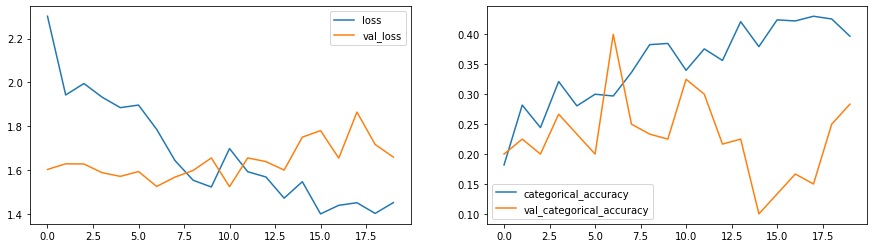

In [24]:
plot(con3D_2_model)

- Here we seen poor validation accuracy and training accuracy with custom cropping size and batch_size of 30 
- We observerd model are overfitting
- categorical_accuracy: 0.3970 ,val_categorical_accuracy: 0.2833

## Trying augmentation with Affline Transformation

In [8]:
# Instead of using a specific size for croping we are using Affline Transformation
def generator3(source_path, folder_list, batch_size,augment,samples,height,width):
    
    frames=30 # In each video  we have 30 image frames
   
    img_idx = np.round(np.linspace(0,frames-1,samples)).astype(int)
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),height,width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
                
            if(augment):
                batch_data_aug=np.zeros((batch_size,len(img_idx),height,width,3))
                
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized=resize(image,(height,width,3)).astype(np.float32)
           
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                    
                    if (augment):
                        shifted = cv2.warpAffine(image,np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),(image.shape[1], image.shape[0]))
                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                        cropped=shifted[x0:x1,y0:y1,:]
                    
                        image_resized=resize(cropped,(height,width,3))
                        
                        M = cv2.getRotationMatrix2D((width//2,height//2),np.random.randint(-10,10), 1.0)
                        rotated = cv2.warpAffine(image_resized, M, (width,height))
                    
                        batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 # OHE
            
            if (augment):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            

        
        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size)!=0:
            batch_data = np.zeros((len(t)%batch_size,len(img_idx),height,width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            
            if(augment):
                batch_data_aug=np.zeros((len(t)%batch_size,len(img_idx),height,width,3))
                
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized=resize(image,(height,width,3)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                    
                    if (augment):
                        shifted = cv2.warpAffine(image,np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),(image.shape[1], image.shape[0]))
                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                        cropped=shifted[x0:x1,y0:y1,:]
                    
                        image_resized=resize(cropped,(height,width,3))
                    
                        M = cv2.getRotationMatrix2D((width//2,height//2),np.random.randint(-10,10), 1.0)
                        rotated = cv2.warpAffine(image_resized, M, (width,height))
                    
                        batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1 # OHE
            
            if(augment):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            yield batch_data, batch_labels


In [51]:
curr_dt_time = datetime.datetime.now()
train_path = path+'/Project_data/Project_data/train'
val_path = path+'/Project_data/Project_data/val'
num_train_sequences = len(train_doc) # 663
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc) # 100
print('# validation sequences =', num_val_sequences)
num_epochs = 22 # choose the number of epochs # 30
print ('# epochs =', num_epochs)

train_generator = generator3(train_path, train_doc,30,True,20,120,120)
val_generator = generator3(val_path, val_doc,30,True,20,120,120)


model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# if #images=55, batch_size=5, then we have 11 batches and 11 epochs
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
# if #images=55, batch_size=5, then we have 11 batches and 3 pending images, therefore 12 epoch will be reqd for last 3 images
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 663
# validation sequences = 100
# epochs = 22


In [52]:
model3 = Sequential()
model3.add(Conv3D(16, (3,3,3), padding='same',input_shape=(20,120,120,3)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(32,(3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(64, (3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(128, (3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Flatten())
model3.add(Dense(64,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(64,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))


model3.add(Dense(5,activation='softmax'))

In [53]:
optimiser = tf.keras.optimizers.Adam(lr=0.002) #write your optimizer
conv3D_3=model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_24 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_25 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 10, 60, 60, 32)   

In [54]:
con3D_3_model=model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/22
11/11 [==============================] - 824s 75s/step - loss: 1.9733 - categorical_accuracy: 0.2636 - val_loss: 2.5615 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2021-10-2415_11_42.783232\model-00001-1.97330-0.26364-2.56153-0.20000.h5
Epoch 2/22
11/11 [==============================] - 768s 70s/step - loss: 1.5914 - categorical_accuracy: 0.3697 - val_loss: 1.9615 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2021-10-2415_11_42.783232\model-00002-1.59135-0.36970-1.96150-0.25000.h5
Epoch 3/22
11/11 [==============================] - 844s 84s/step - loss: 1.3847 - categorical_accuracy: 0.4406 - val_loss: 1.7738 - val_categorical_accuracy: 0.2250

Epoch 00003: saving model to model_init_2021-10-2415_11_42.783232\model-00003-1.38473-0.44059-1.77382-0.22500.h5
Epoch 4/22
11/11 [==============================] - 1061s 97s/step - loss: 1.2994 - categorical_accuracy: 0.4742 - val_loss: 1.7842 - val_categorical_accuracy: 

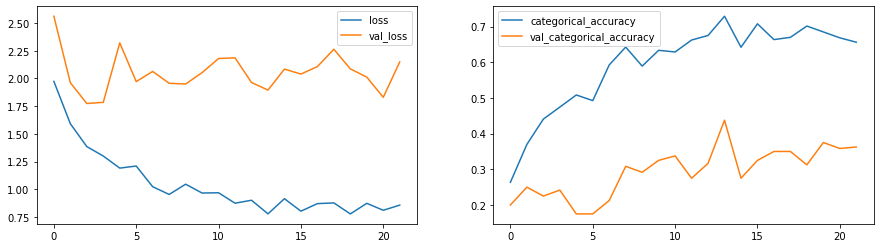

In [55]:
plot(con3D_3_model)

    - Here we get better accuracy than previous model after applying affline transformation [Crop,Rotation]
    - we observed that accuracy incrasing after each epoch continously with stable validation accuracy .
    - model are completely overfitting .
    - so now we are trying more dense CNN with more parameters and for overfitting we apply dropout increases to 50% .

# Adding More Layes - increasing parameter

In [31]:
model4 = Sequential()
model4.add(Conv3D(16,(3,3,3), padding='same',input_shape=(18,120,120,3)))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Conv3D(32,(3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Conv3D(64, (3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Conv3D(128, (3,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Flatten())
model4.add(Dense(256,activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

model4.add(Dense(256,activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))


model4.add(Dense(5,activation='softmax'))

In [32]:
curr_dt_time = datetime.datetime.now()
train_path = path+'/Project_data/Project_data/train'
val_path = path+'/Project_data/Project_data/val'
num_train_sequences = len(train_doc) # 663
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc) # 100
print('# validation sequences =', num_val_sequences)
num_epochs = 22 # choose the number of epochs # 30
print ('# epochs =', num_epochs)

batch_size=64

train_generator = generator3(train_path, train_doc,batch_size,True,18,120,120)
val_generator = generator3(val_path, val_doc,batch_size,True,18,120,120)


model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# if #images=55, batch_size=5, then we have 11 batches and 11 epochs
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
# if #images=55, batch_size=5, then we have 11 batches and 3 pending images, therefore 12 epoch will be reqd for last 3 images
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 663
# validation sequences = 100
# epochs = 22


In [33]:
optimiser = tf.keras.optimizers.Adam(lr=0.0002)
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 18, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 18, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 18, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 9, 60, 60, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 9, 60, 60, 32)     13856     
_________________________________________________________________
activation_9 (Activation)    (None, 9, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 9, 60, 60, 32)    

In [34]:
con3D_4_model=model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/22
11/11 [==============================] - 1682s 156s/step - loss: 2.3764 - categorical_accuracy: 0.2790 - val_loss: 1.6716 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-10-2516_19_30.534867\model-00001-2.37638-0.27903-1.67162-0.16000.h5
Epoch 2/22
11/11 [==============================] - 1719s 154s/step - loss: 1.6257 - categorical_accuracy: 0.4374 - val_loss: 1.7632 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2021-10-2516_19_30.534867\model-00002-1.62573-0.43741-1.76321-0.21000.h5
Epoch 3/22
11/11 [==============================] - 1858s 170s/step - loss: 1.3594 - categorical_accuracy: 0.5075 - val_loss: 2.1734 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2021-10-2516_19_30.534867\model-00003-1.35935-0.50754-2.17340-0.16000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 4/22
11/11 [==============================] - 1942s 177s/step - los

KeyboardInterrupt: 

- model are getting overfitting lets see accuracy by using CNN-RNN Architecture

# CNN-RNN

# Transfer learning with Not GRU trainable parameter

In [15]:
from keras.applications import mobilenet
from keras.layers.convolutional import Conv2D,MaxPooling2D

mobilenet_transfer = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False)
        
model6 = Sequential()
model6.add(TimeDistributed(mobilenet_transfer, input_shape=(15,120,120,3)))

for layer in mobilenet_transfer.layers:
    layer.trainable = False
    
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))
model6.add(TimeDistributed(Flatten()))

model6.add(GRU(64))
model6.add(Dropout(0.25))

model6.add(Dense(64,activation='relu'))
model6.add(Dropout(0.25))

model6.add(Dense(5, activation='softmax'))

In [16]:
curr_dt_time = datetime.datetime.now()
train_path = path+'/Project_data/Project_data/train'
val_path = path+'/Project_data/Project_data/val'
num_train_sequences = len(train_doc) # 663
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc) # 100
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs # 30
print ('# epochs =', num_epochs)

batch_size=64

train_generator = generator3(train_path, train_doc,batch_size,True,15,120,120)
val_generator = generator3(val_path, val_doc,batch_size,True,15,120,120)


model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# if #images=55, batch_size=5, then we have 11 batches and 11 epochs
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
# if #images=55, batch_size=5, then we have 11 batches and 3 pending images, therefore 12 epoch will be reqd for last 3 images
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [17]:
optimiser = tf.keras.optimizers.Adam(lr=0.0002)
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 3, 3, 1280)    2257984   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 3, 3, 1280)    5120      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 1, 1, 1280)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 1280)          0         
_________________________________________________________________
gru (GRU)                    (None, 64)                258432    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [18]:
cnn_rnn_6_model=model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
11/11 [==============================] - 371s 35s/step - loss: 1.6667 - categorical_accuracy: 0.2707 - val_loss: 1.4991 - val_categorical_accuracy: 0.3350

Epoch 00001: saving model to model_init_2021-10-2423_52_04.783845\model-00001-1.66668-0.27074-1.49915-0.33500.h5
Epoch 2/30
11/11 [==============================] - 364s 35s/step - loss: 1.4598 - categorical_accuracy: 0.3922 - val_loss: 1.4068 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2021-10-2423_52_04.783845\model-00002-1.45976-0.39216-1.40677-0.40000.h5
Epoch 3/30
11/11 [==============================] - 358s 35s/step - loss: 1.3054 - categorical_accuracy: 0.4608 - val_loss: 1.2443 - val_categorical_accuracy: 0.5150

Epoch 00003: saving model to model_init_2021-10-2423_52_04.783845\model-00003-1.30538-0.46078-1.24433-0.51500.h5
Epoch 4/30
11/11 [==============================] - 344s 33s/step - loss: 1.1557 - categorical_accuracy: 0.5633 - val_loss: 1.1586 - val_categorical_accuracy: 0

11/11 [==============================] - 263s 25s/step - loss: 0.3782 - categorical_accuracy: 0.8959 - val_loss: 0.6116 - val_categorical_accuracy: 0.7600

Epoch 00029: saving model to model_init_2021-10-2423_52_04.783845\model-00029-0.37816-0.89593-0.61156-0.76000.h5
Epoch 30/30
11/11 [==============================] - 258s 25s/step - loss: 0.3746 - categorical_accuracy: 0.8967 - val_loss: 0.5542 - val_categorical_accuracy: 0.7850

Epoch 00030: saving model to model_init_2021-10-2423_52_04.783845\model-00030-0.37463-0.89668-0.55423-0.78500.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1e-05.


# Transfer learning with GRU trainable parameter

In [19]:
from keras.layers.convolutional import Conv2D,MaxPooling2D

mobilenet_transfer = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False)
        
model6 = Sequential()
model6.add(TimeDistributed(mobilenet_transfer, input_shape=(15,120,120,3)))
    
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))
model6.add(TimeDistributed(Flatten()))

model6.add(GRU(64))
model6.add(Dropout(0.25))

model6.add(Dense(64,activation='relu'))
model6.add(Dropout(0.25))

model6.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(lr=0.002)
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [20]:
curr_dt_time = datetime.datetime.now()
train_path = path+'/Project_data/Project_data/train'
val_path = path+'/Project_data/Project_data/val'
num_train_sequences = len(train_doc) # 663
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc) # 100
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs # 30
print ('# epochs =', num_epochs)

batch_size=20

train_generator = generator3(train_path, train_doc,batch_size,True,15,120,120)
val_generator = generator3(val_path, val_doc,batch_size,True,15,120,120)


model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

# if #images=55, batch_size=5, then we have 11 batches and 11 epochs
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
# if #images=55, batch_size=5, then we have 11 batches and 3 pending images, therefore 12 epoch will be reqd for last 3 images
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [21]:
optimiser = tf.keras.optimizers.Adam(lr=0.0002)
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 15, 3, 3, 1280)    2257984   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 3, 3, 1280)    5120      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 1, 1, 1280)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 15, 1280)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                258432    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

In [22]:
cnn_rnn_6_model=model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
34/34 [==============================] - 1021s 30s/step - loss: 1.5562 - categorical_accuracy: 0.3567 - val_loss: 1.2717 - val_categorical_accuracy: 0.5050

Epoch 00001: saving model to model_init_2021-10-2502_23_44.550991\model-00001-1.55621-0.35671-1.27165-0.50500.h5
Epoch 2/30
34/34 [==============================] - 998s 29s/step - loss: 0.9811 - categorical_accuracy: 0.6478 - val_loss: 1.0611 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2021-10-2502_23_44.550991\model-00002-0.98105-0.64781-1.06114-0.61000.h5
Epoch 3/30
34/34 [==============================] - 995s 29s/step - loss: 0.6040 - categorical_accuracy: 0.8130 - val_loss: 0.9147 - val_categorical_accuracy: 0.7100

Epoch 00003: saving model to model_init_2021-10-2502_23_44.550991\model-00003-0.60396-0.81297-0.91469-0.71000.h5
Epoch 4/30
34/34 [==============================] - 993s 29s/step - loss: 0.4083 - categorical_accuracy: 0.8756 - val_loss: 0.7351 - val_categorical_accuracy: 

Epoch 29/30
34/34 [==============================] - 1040s 31s/step - loss: 0.0352 - categorical_accuracy: 0.9947 - val_loss: 0.2053 - val_categorical_accuracy: 0.9400

Epoch 00029: saving model to model_init_2021-10-2502_23_44.550991\model-00029-0.03523-0.99472-0.20531-0.94000.h5
Epoch 30/30
34/34 [==============================] - 1227s 36s/step - loss: 0.0414 - categorical_accuracy: 0.9955 - val_loss: 0.2612 - val_categorical_accuracy: 0.9300

Epoch 00030: saving model to model_init_2021-10-2502_23_44.550991\model-00030-0.04140-0.99548-0.26123-0.93000.h5


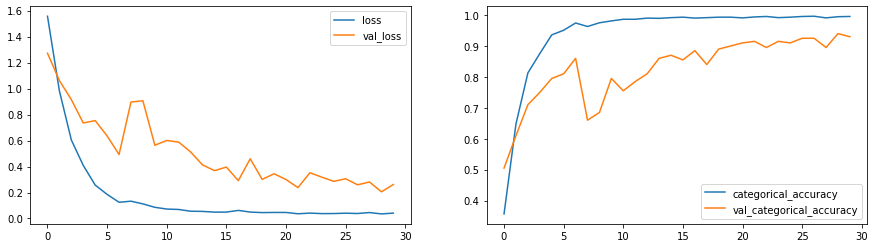

In [35]:
plot(cnn_rnn_6_model)

- Here we found best validation accuracy be 93% from last conv3D models

# Loading Model and Testing

In [7]:
import time
from keras.models import load_model
model = load_model(os.getcwd()+"\\model_init_2021-10-2502_23_44.550991\\model-00030-0.04140-0.99548-0.26123-0.93000.h5")

> Thumbs up:  Increase the volume -- 4

> Thumbs down: Decrease the volume -- 3

> Left swipe: 'Jump' backwards 10 seconds -- 0

> Right swipe: 'Jump' forward 10 seconds  -- 1

> Stop: Pause the movie -- 2

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = path+'/Project_data/Project_data/train'
val_path = path+'/Project_data/Project_data/val'
num_train_sequences = len(train_doc) # 663
num_val_sequences = len(val_doc) # 100
num_epochs = 1


batch_size=7
test_generator = generator3(train_path, train_doc,batch_size,True,20,120,120)
batch_data, batch_labels=next(test_generator)

In [10]:
batch_labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [11]:
np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1)

array([1, 2, 2, 4, 0, 4, 4, 1, 2, 2, 4, 0, 4, 4], dtype=int64)